              precision    recall  f1-score   support

        mild     0.6667    0.4444    0.5333        36
        safe     0.7308    0.9828    0.8382        58
      severe     1.0000    0.7500    0.8571         4
       toxic     0.8000    0.4706    0.5926        17

    accuracy                         0.7304       115
   macro avg     0.7994    0.6619    0.7053       115
weighted avg     0.7303    0.7304    0.7071       115



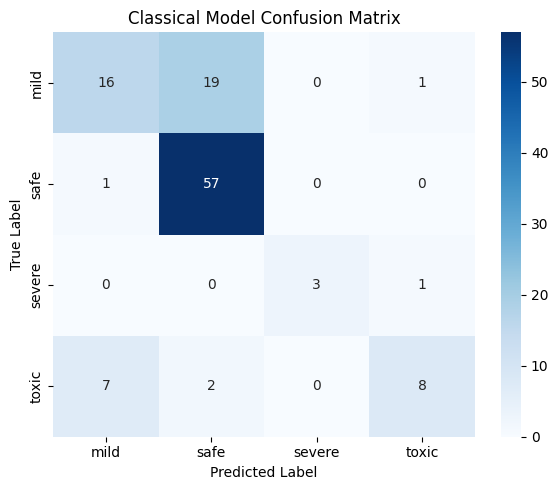

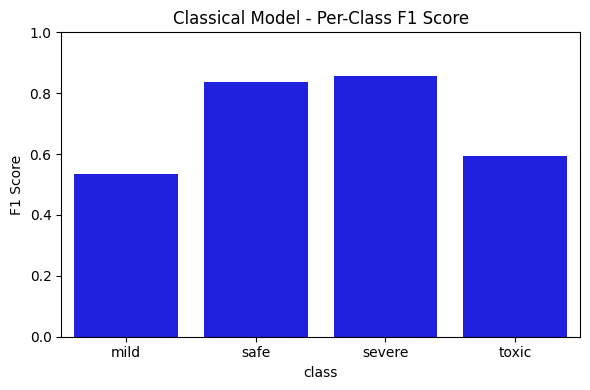


Metrics saved to ../results/metrics/phase1_classical_metrics_all_round_comments.json


In [1]:
import os
import pandas as pd
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from scipy.sparse import hstack
import json

# =============================
# Load Data
# =============================
df = pd.read_csv("../data/test/forum_test_dataset.csv")
X = df['cleaned_comment']
y = df['expected_label']

# =============================
# Load Model and Vectorizer
# =============================
le = joblib.load("../models/saved/classical/label_encoder.pkl")
y_enc = le.transform(y)
vectorizer = joblib.load("../models/saved/classical/vectorizer.pkl")
model = joblib.load("../models/saved/classical/xgboost.pkl")

X_vec = vectorizer.transform(X)

# =============================
# Generate Numeric Features
# =============================
def count_features(text):
    return pd.Series({
        "char_count": len(text),
        "word_count": len(text.split()),
        "num_uppercase": sum(1 for c in text if c.isupper()),
        "num_exclamation": text.count("!"),
        "num_question": text.count("?"),
        "has_swear": int(any(bad in text.lower() for bad in ["fuck", "shit", "idiot", "stupid", "dumb"]))
    })

df_features = df["cleaned_comment"].apply(count_features)
X_num = df_features.values

X_combined = hstack([X_vec, X_num])

# =============================
# Predict
# =============================
y_pred_enc = model.predict(X_combined)
y_pred = le.inverse_transform(y_pred_enc)

# =============================
# Classification Report & Confusion Matrix
# =============================
print(classification_report(y, y_pred, target_names=le.classes_, digits=4))

cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title("Classical Model Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

# =============================
# Per-Class F1 Score Visualization
# =============================
report = classification_report(y, y_pred, target_names=le.classes_, output_dict=True)
f1_scores = [report[label]['f1-score'] for label in le.classes_]

df_f1 = pd.DataFrame({"class": le.classes_, "f1_score": f1_scores})
plt.figure(figsize=(6,4))
sns.barplot(data=df_f1, x="class", y="f1_score", color="blue")
plt.title("Classical Model - Per-Class F1 Score")
plt.ylabel("F1 Score")
plt.ylim(0,1)
plt.tight_layout()
plt.show()

# =============================
# Save Metrics
# =============================
results_dir = "../results/metrics"
os.makedirs(results_dir, exist_ok=True)

results = {
    "model": "Classical_XGBoost",
    "accuracy": (y_pred == y).mean(),
    "macro_f1": float(np.mean(f1_scores)),
    "per_class_f1": {label: float(report[label]['f1-score']) for label in le.classes_}
}

metrics_path = os.path.join(results_dir, "phase1_classical_metrics_all_round_comments.json")
with open(metrics_path, "w") as f:
    json.dump(results, f, indent=4)

print(f"\nMetrics saved to {metrics_path}")